In [2]:
# 1. Import libraries
import pandas as pd
import re
import string
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [3]:
# Step 2: Load dataset (NO HEADER in CSV)
df = pd.read_csv('twitter_training.csv', header=None)

# Assign proper column names manually
df.columns = ['tweet_id', 'entity', 'sentiment', 'text']

# Keep only the needed columns
df = df[['text', 'sentiment']]
df.dropna(inplace=True)  # Remove any rows with missing values

# Optional: See a preview
df.head()




,text,sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


In [4]:
# Step 3: Clean the tweet text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)         # Remove mentions
    text = re.sub(r'#', '', text)                      # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text)                # Remove retweet
    text = re.sub(r'https?:\/\/\S+', '', text)         # Remove URLs
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()           # Normalize whitespace
    return text

df['cleaned_text'] = df['text'].apply(clean_text)


In [5]:
# Step 4: Prepare the dataset
X = df['cleaned_text']
y = df['sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [6]:
# Step 5: Train Logistic Regression with higher max_iter
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)



LogisticRegression(max_iter=1000)

In [7]:
# Step 6: Evaluate the model
y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6761486486486487

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.68      0.49      0.57      2696
    Negative       0.70      0.78      0.74      4380
     Neutral       0.64      0.62      0.63      3605
    Positive       0.67      0.74      0.70      4119

    accuracy                           0.68     14800
   macro avg       0.67      0.66      0.66     14800
weighted avg       0.68      0.68      0.67     14800



In [8]:
# Step 7: Save the model and vectorizer
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully.")


Model and vectorizer saved successfully.


In [10]:
# Load model and vectorizer
model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Predict function
def predict_sentiment(tweet):
    cleaned = clean_text(tweet)
    vec = vectorizer.transform([cleaned])
    prediction = model.predict(vec)
    return prediction[0]

# Example
print(predict_sentiment(" this fucking game!"))
print(predict_sentiment("This app is fucking terrible."))


Negative
Negative


In [16]:
!pip install matplotlib seaborn scikit-learn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)


<Figure size 1000x800 with 0 Axes>

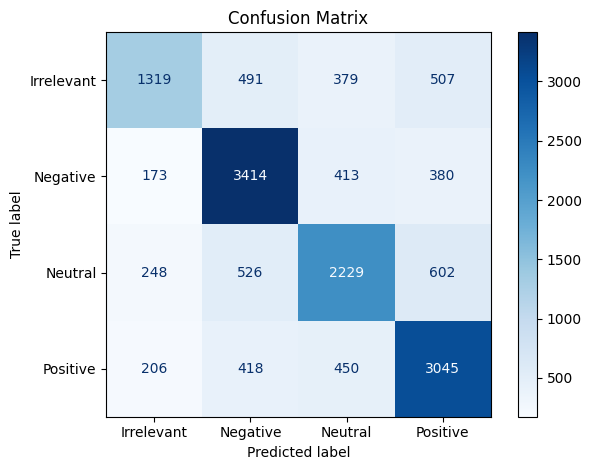

In [17]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

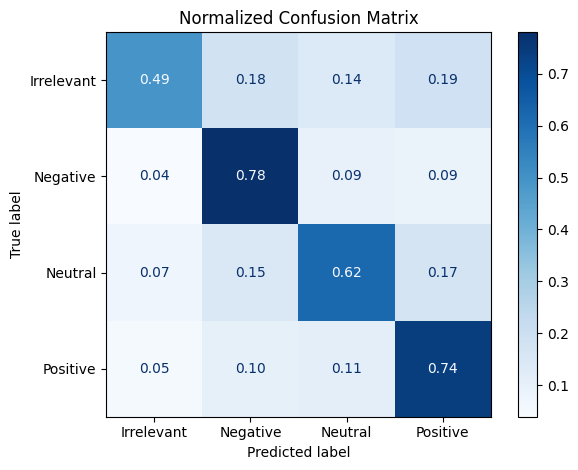

In [18]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np


In [20]:
# For binary classification (assuming 'Positive' is the positive class)
# Get the probability estimates for the positive class
y_test_binary = np.array([1 if label == 'Positive' else 0 for label in y_test])
y_score = model.predict_proba(X_test_vec)[:, 1]  # Probability for positive class

In [21]:
# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_binary, y_score)
roc_auc = auc(fpr, tpr)


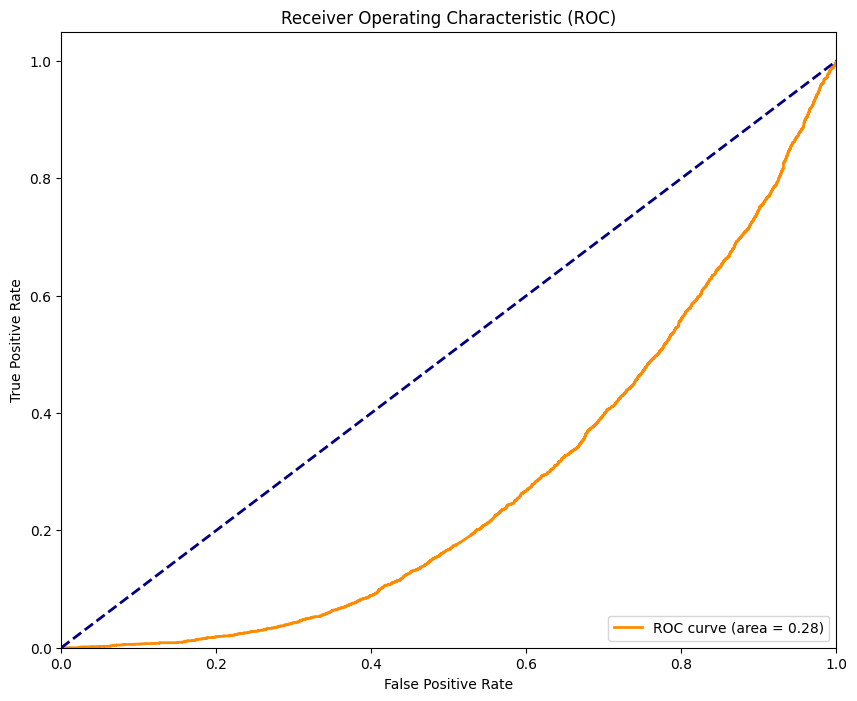

In [22]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [23]:
# For multiclass classification (if you have more than 2 classes)
# One-vs-Rest approach
n_classes = len(model.classes_)
y_test_onehot = np.zeros((len(y_test), n_classes))
for i, label in enumerate(model.classes_):
    y_test_onehot[:, i] = (y_test == label)


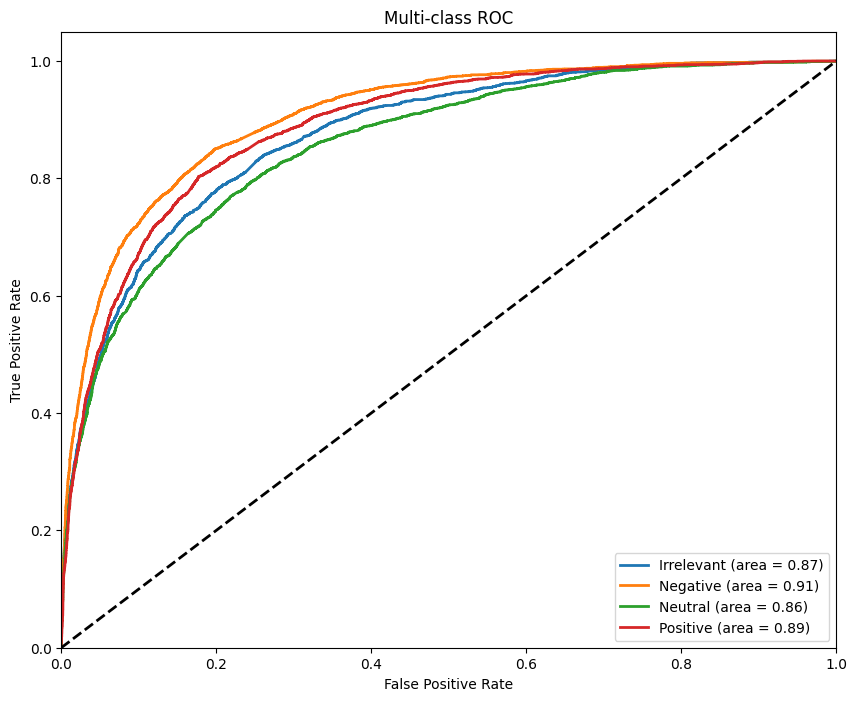

In [24]:
# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 8))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], model.predict_proba(X_test_vec)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Import additional libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
from sklearn.calibration import calibration_curve


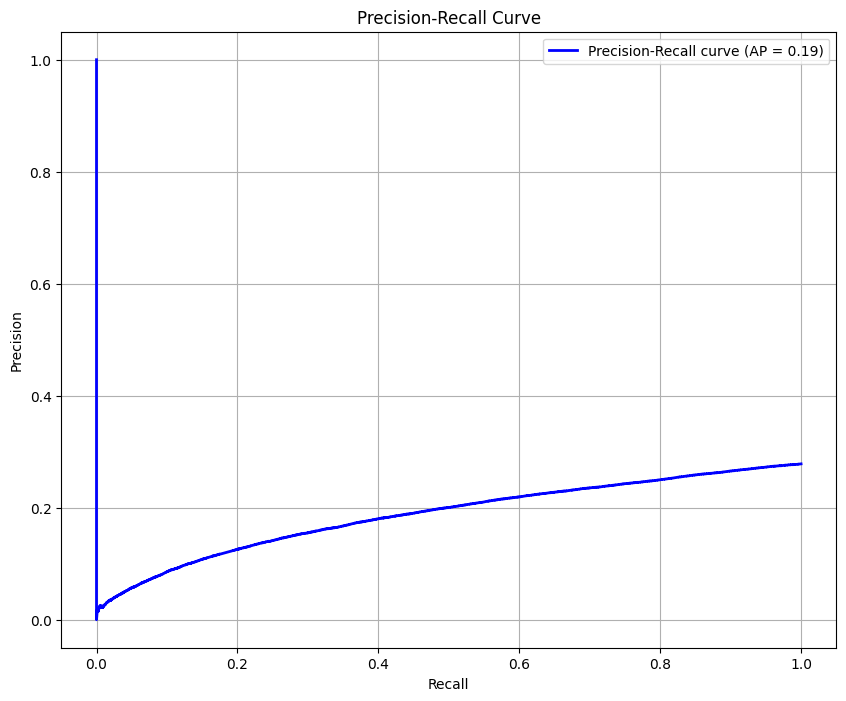

In [26]:
# 1. Precision-Recall Curve
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_test_binary, y_score)
avg_precision = average_precision_score(y_test_binary, y_score)

plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

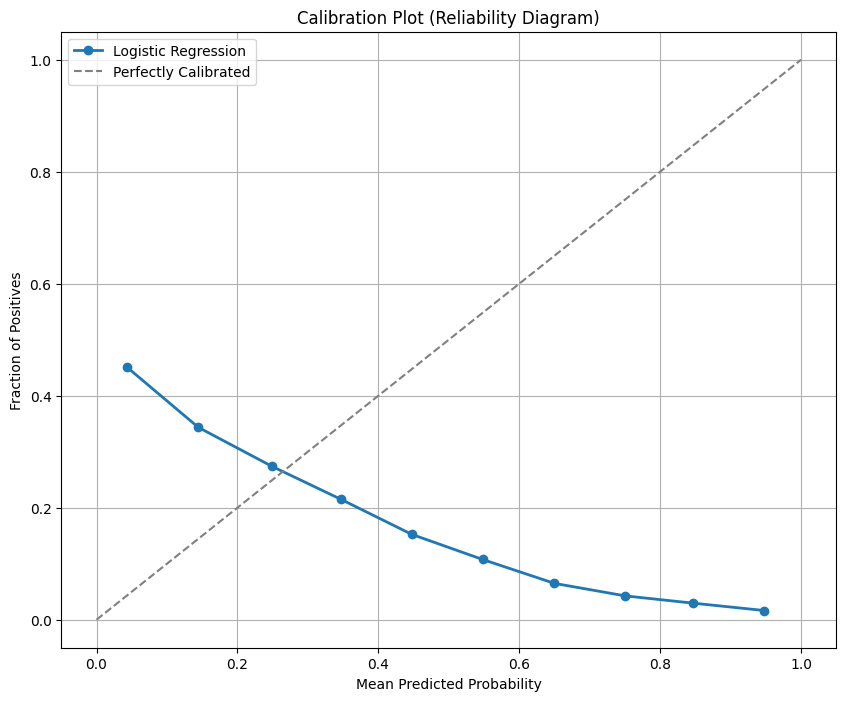

In [27]:
# 2. Calibration Plot (Reliability Diagram)
plt.figure(figsize=(10, 8))
prob_true, prob_pred = calibration_curve(y_test_binary, y_score, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot (Reliability Diagram)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


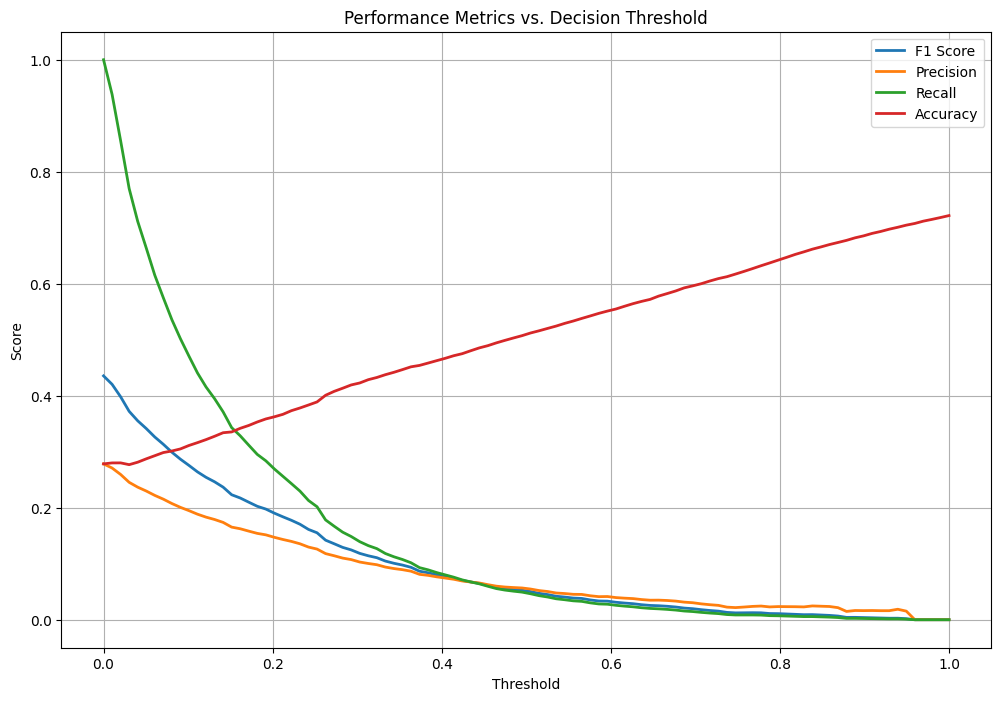

In [28]:
# 3. Decision Threshold Analysis
thresholds = np.linspace(0, 1, 100)
f1_scores = []
precisions = []
recalls = []
accuracies = []

for threshold in thresholds:
    y_pred_threshold = (y_score >= threshold).astype(int)
    f1_scores.append(f1_score(y_test_binary, y_pred_threshold))
    precisions.append(sum((y_pred_threshold == 1) & (y_test_binary == 1)) / 
                     max(sum(y_pred_threshold == 1), 1))
    recalls.append(sum((y_pred_threshold == 1) & (y_test_binary == 1)) / 
                  max(sum(y_test_binary == 1), 1))
    accuracies.append(sum(y_pred_threshold == y_test_binary) / len(y_test_binary))

plt.figure(figsize=(12, 8))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, accuracies, label='Accuracy', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Decision Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

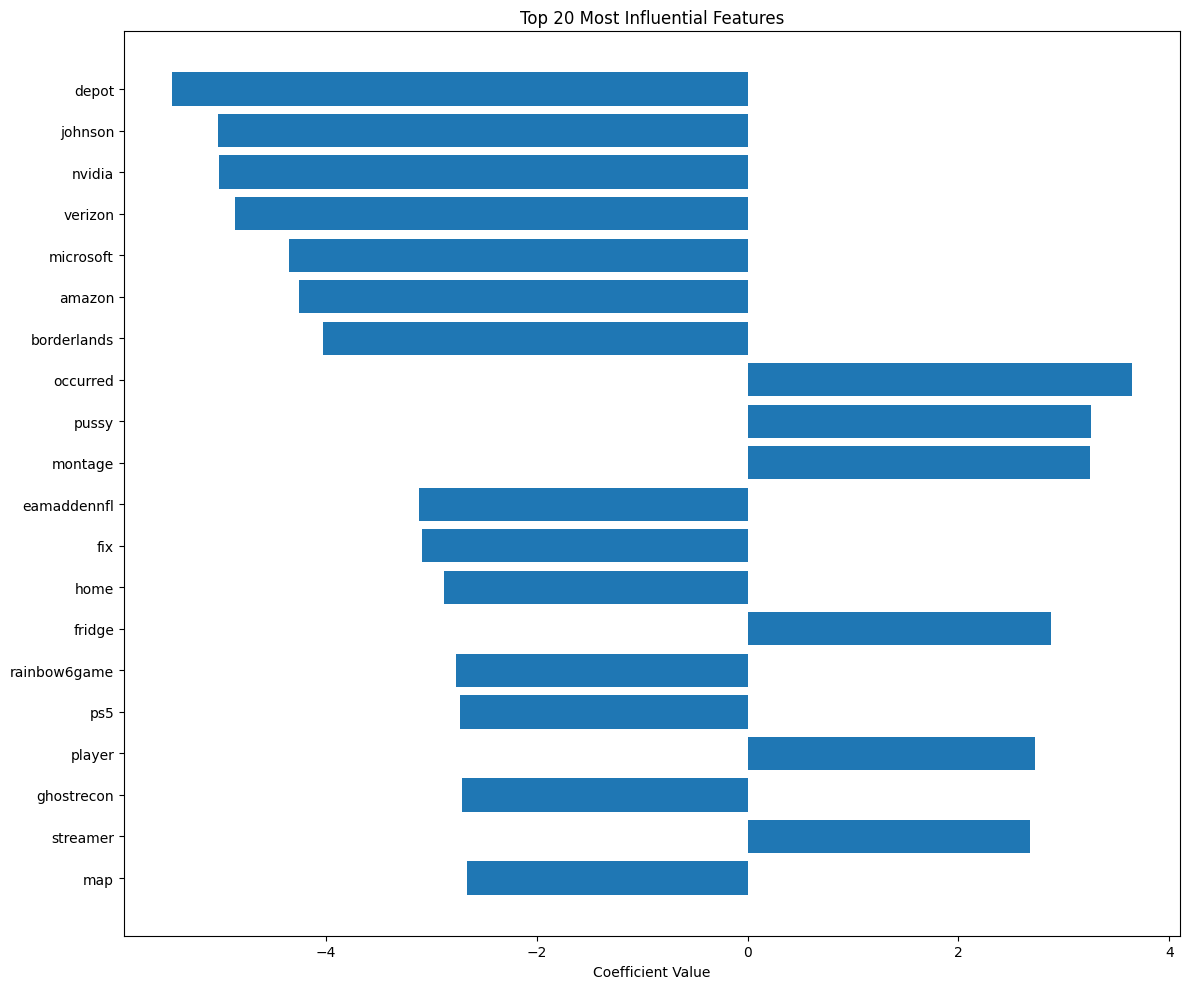

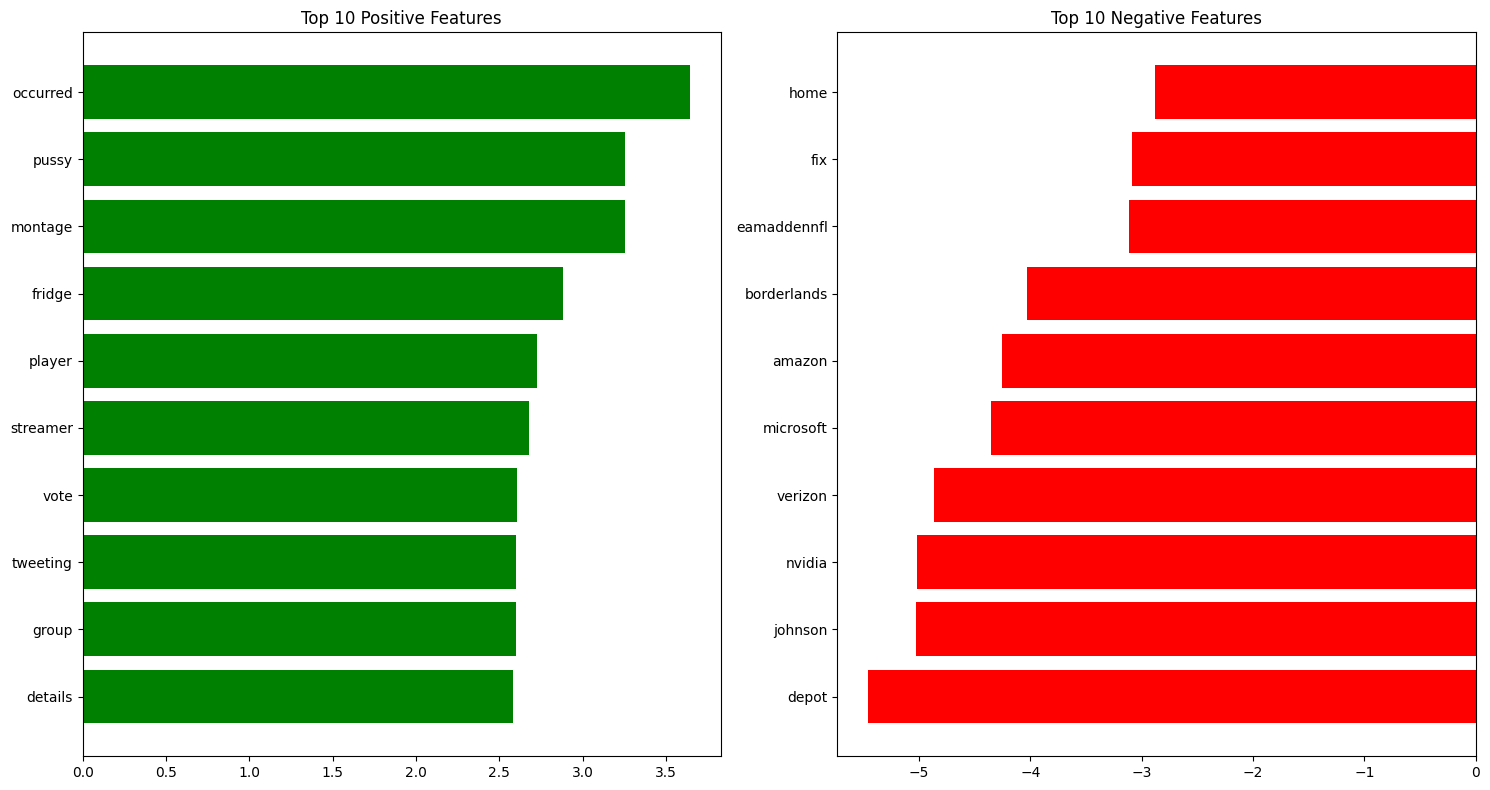

In [29]:
# 4. Feature Importance Visualization
if hasattr(model, 'coef_'):
    # Get feature names and coefficients
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_[0]
    
    # Sort by absolute value
    indices = np.argsort(np.abs(coefficients))[-20:]  # Top 20 features
    
    plt.figure(figsize=(12, 10))
    plt.barh(range(len(indices)), coefficients[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Coefficient Value')
    plt.title('Top 20 Most Influential Features')
    plt.tight_layout()
    plt.show()
    
    # Separate positive and negative influences
    positive_indices = np.argsort(coefficients)[-10:]  # Top 10 positive
    negative_indices = np.argsort(coefficients)[:10]   # Top 10 negative
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    ax1.barh(range(len(positive_indices)), coefficients[positive_indices], align='center', color='green')
    ax1.set_yticks(range(len(positive_indices)))
    ax1.set_yticklabels([feature_names[i] for i in positive_indices])
    ax1.set_title('Top 10 Positive Features')
    
    ax2.barh(range(len(negative_indices)), coefficients[negative_indices], align='center', color='red')
    ax2.set_yticks(range(len(negative_indices)))
    ax2.set_yticklabels([feature_names[i] for i in negative_indices])
    ax2.set_title('Top 10 Negative Features')
    
    plt.tight_layout()
    plt.show()

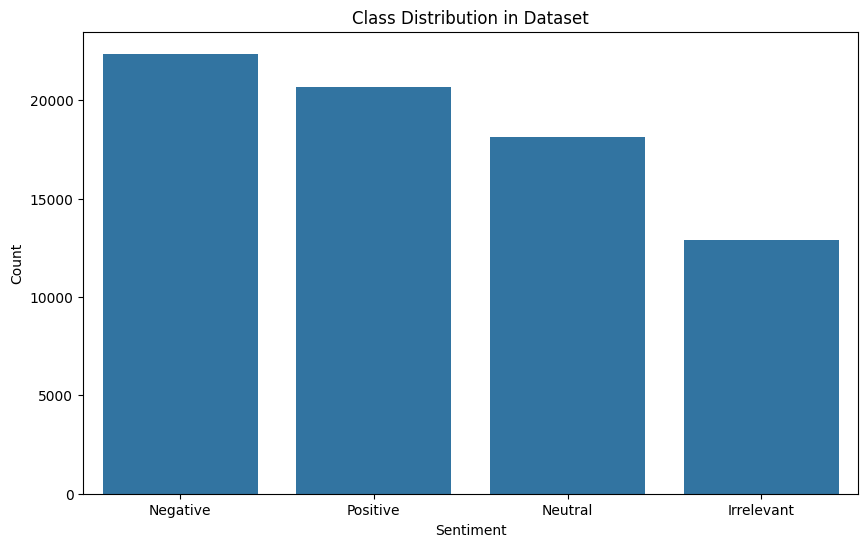

In [31]:
# 2. Class Distribution Visualization
plt.figure(figsize=(10, 6))
class_counts = y.value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [32]:
# 3. Error Analysis - examine misclassified examples
misclassified_indices = np.where(y_pred != y_test)[0]
if len(misclassified_indices) > 0:
    sample_size = min(10, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)
    
    print("Sample of Misclassified Examples:")
    for idx in sample_indices:
        print(f"Text: {X_test.iloc[idx]}")
        print(f"True label: {y_test.iloc[idx]}")
        print(f"Predicted label: {y_pred[idx]}")
        probs = model.predict_proba(vectorizer.transform([X_test.iloc[idx]]))[0]
        for i, label in enumerate(model.classes_):
            print(f"  Probability of '{label}': {probs[i]:.4f}")
        print("-" * 50)


Sample of Misclassified Examples:
Text: no no no no why are you guys making
True label: Irrelevant
Predicted label: Negative
  Probability of 'Irrelevant': 0.1067
  Probability of 'Negative': 0.8038
  Probability of 'Neutral': 0.0692
  Probability of 'Positive': 0.0203
--------------------------------------------------
Text: either the cpu on madden is trash on allmadden difficulty or im just too good hope eamaddennf21 would give me more of a challenge
True label: Neutral
Predicted label: Negative
  Probability of 'Irrelevant': 0.0740
  Probability of 'Negative': 0.4643
  Probability of 'Neutral': 0.3615
  Probability of 'Positive': 0.1003
--------------------------------------------------
Text: apparentally if you have verizon as that wallet valorant says while you
True label: Negative
Predicted label: Neutral
  Probability of 'Irrelevant': 0.0133
  Probability of 'Negative': 0.2148
  Probability of 'Neutral': 0.6979
  Probability of 'Positive': 0.0739
--------------------------------

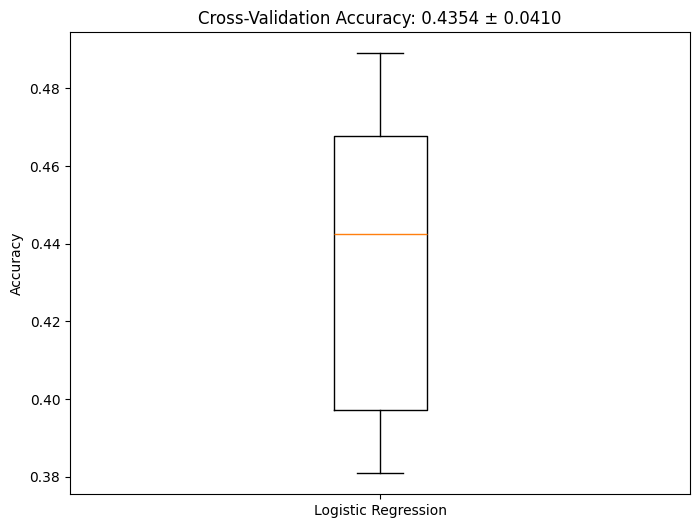

In [33]:
# 4. Cross-Validation Performance
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(
    LogisticRegression(max_iter=1000), 
    vectorizer.fit_transform(X), y, 
    cv=5, scoring='accuracy'
)

plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores)
plt.title(f'Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
plt.ylabel('Accuracy')
plt.xticks([1], ['Logistic Regression'])
plt.show()

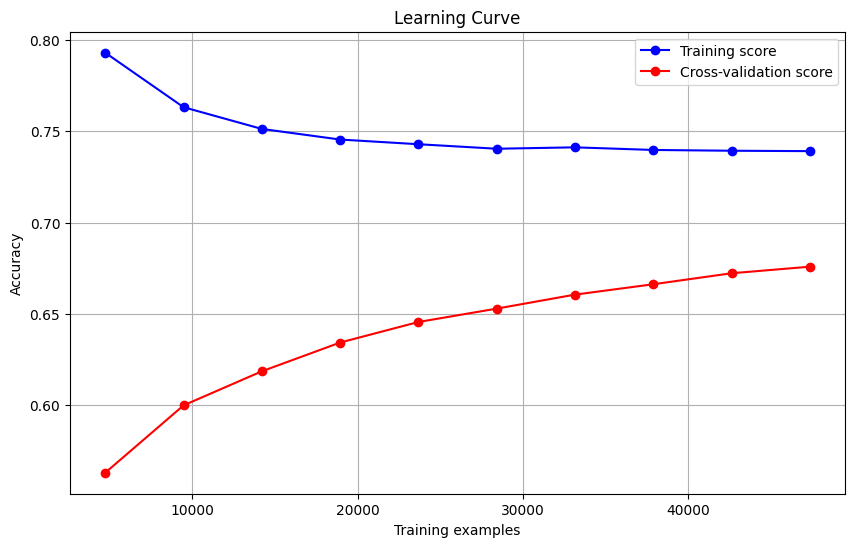

In [34]:
# 1. Learning Curve - shows how model performance changes with training set size
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000), X_train_vec, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='red', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [35]:
!pip install wordcloud

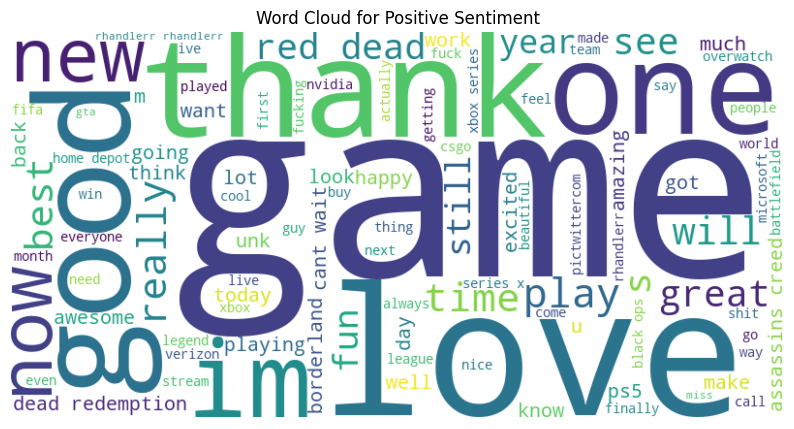

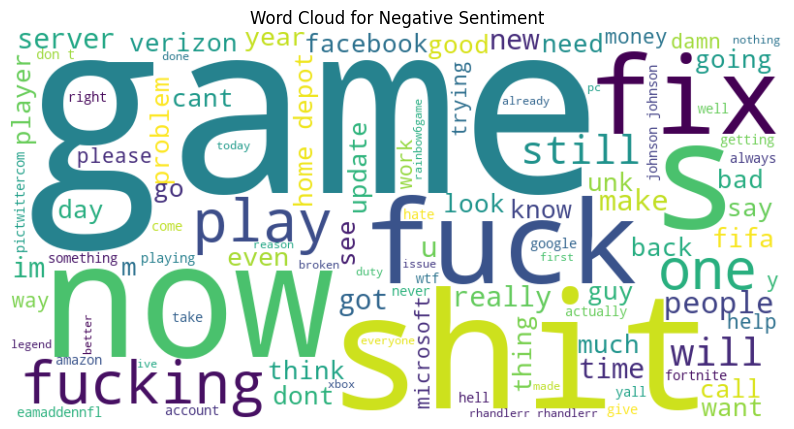

In [36]:
from wordcloud import WordCloud

# For positive sentiment
positive_text = ' '.join(X[y == 'Positive'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, contour_width=3, contour_color='steelblue')
wordcloud_positive.generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
plt.show()

# For negative sentiment
negative_text = ' '.join(X[y == 'Negative'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white',
                              max_words=100, contour_width=3, contour_color='firebrick')
wordcloud_negative.generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')
plt.show()